In [3]:
from src.Prepare_Data import *
from src.Models import *
from src.Test import *
import os 
if os.path.isdir("scalers")==False:
    os.mkdir("scalers")
if os.path.isdir("models")==False:
    os.mkdir("models")


Using TensorFlow backend.


In [4]:
modelNumber=1
# 1: Basic LSTM Model 
# 2: Input Features first goes throush encoder, Then given to LSTM. 
# 3: Image CNN LSTM
features=1
# features= 0:No Features,1:Support Points,2:ShapeContext,3:AutoEncoder,4:Image
FeatureSize=4 #(128,128,1)
# FeatureSize= No Feature:0,Support Points:4, ShapeContext:110,420,1640,AutoEncoder:256,512,1024 Image:(128,128,1)


In [5]:
## Model Parameters:
seq_length=15
n_neurons=128

In [6]:
if modelNumber==1:
    model = model_type_1(n_neurons,seq_length, FeatureSize+6)
elif modelNumber==2:
    model = model_type_2(n_neurons,seq_length, FeatureSize+6)
elif modelNumber==3:
    model = model_type_3(n_neurons,seq_length, FeatureSize)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
from IPython.display import clear_output
import keras
errors=list()
class plt_cb(keras.callbacks.Callback):
    def __init__(self,modelNumber,features,FeatureSize,seq_length,model,errors,n_steps=1):
        self.errors=errors
        self.loss=list()
        self.val_loss=list()
        self.modelNumber=modelNumber
        self.features=features
        self.n_steps=n_steps
        self.FeatureSize=FeatureSize
        self.seq_length=seq_length
        self.model=model
        
    def on_epoch_end(self,epoch, logs={}):
        clear_output()
        val_error,var_error_std=validate_model(self.modelNumber,self.features,self.FeatureSize,self.seq_length,self.model,self.n_steps)
        self.errors.append(val_error)
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        logs['rollout_error']=val_error
        print 'EPOCH:',epoch
        print '----------------'
        plt.figure()
        plt.plot(np.log(np.array(self.loss)))
        plt.plot(np.log(np.array(self.val_loss)))
        plt.show()
        plt.figure()
        plt.plot(np.log(np.array(self.errors)))
        plt.show()
errors=list()
plt_callback=plt_cb(modelNumber,features,FeatureSize,seq_length,model,errors)
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,verbose=1, patience=5, mode='auto', cooldown=5)
save_model= keras.callbacks.ModelCheckpoint('weights.{epoch:02d}.hdf5', monitor='rollout_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)


# Training

Total XYZ MSE Error Mean=0.78 Std=0.49
EPOCH: 53
----------------


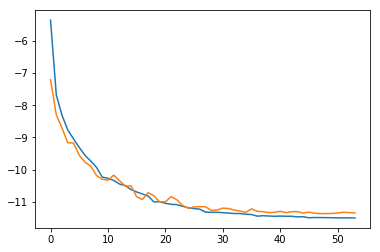

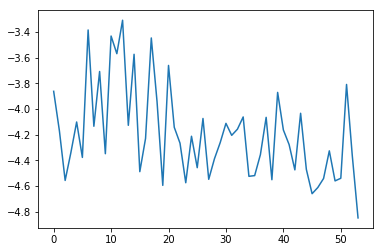

Epoch 55/100
35392/38584 [==========================>...] - ETA: 0s - loss: 9.8141e-06

In [ ]:
import pickle
bestErrors=dict()
modelNumber=2
features=1
# features= 0:No Features,1:Support Points,2:ShapeContext,3:AutoEncoder,4:Image
FeatureSize=4 
# FeatureSize= No Feature:0,Support Points:4, ShapeContext:110,420,1640,AutoEncoder:256,512,1024 Image:(128,128,1)
if modelNumber==1:
    for seq_length in [15,]:
        x,y = prepare_data_for_model(modelNumber,features,FeatureSize,seq_length,32,5)
        for batc_size in [64,]:
            for n_neurons in [128,]:
                for lr in np.arange(0.0001,0.0011,0.0003):
                    model= model_type_1(n_neurons,seq_length, FeatureSize+6,lr)
                    errors=list()
                    plt_callback=plt_cb(modelNumber,features,FeatureSize,seq_length,model,errors)
                    reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,verbose=1, patience=5, mode='auto', cooldown=5)
                    model.fit(x,y,validation_split=0.05,batch_size=batc_size,epochs=100,callbacks=[reduce_lr,plt_callback])

if modelNumber==2:
    for seq_length in [15,]:
        x,y = prepare_data_for_model(modelNumber,features,FeatureSize,seq_length,64,1)
        for batc_size in [64,]:
            for n_neurons in [128,]:
                for lr in [0.0008]:
                    model = model_type_2(n_neurons,seq_length, FeatureSize+6,0.1,4096,lr,1)
                    errors=list()
                    plt_callback=plt_cb(modelNumber,features,FeatureSize,seq_length,model,errors,1)
                    reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,verbose=1, patience=5, mode='auto', cooldown=5)
                    model.fit(x,y,validation_split=0.05,batch_size=batc_size,epochs=100,callbacks=[reduce_lr,plt_callback])
                    bestErrors[(n_neurons,batc_size,lr,seq_length)]=(np.argmin(errors),min(errors))

if modelNumber==3:
    for batc_size in [64,]:
        for seq_length in [15,]:
            TrainDg,valDg=prepare_data_for_model(modelNumber,features,FeatureSize,seq_length,batc_size)
            for lr in np.arange(0.0001,0.0011,0.0001):
                for dropout in [0.25,]:#np.arange(0.1,0.6,0.1):
                    for layer_size in [256,]:#np.power(2,range(7,13)):
                        for n_neurons in [512,]:#np.power(2,range(7,10)):
                            print "---------",(n_neurons,batc_size,lr,dropout,layer_size,seq_length),'-----------------'
                            model = model_type_3(n_neurons,seq_length, FeatureSize,dropout,layer_size,lr)
                            errors=list()
                            plt_callback=plt_cb(modelNumber,features,FeatureSize,seq_length,model,errors)
                            reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8,verbose=1, patience=5, mode='auto', cooldown=5)
                            #save_model= keras.callbacks.ModelCheckpoint('weights.{epoch:02d}.hdf5', monitor='rollout_error', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
                            model.fit_generator(generator=TrainDg,
                                validation_data=valDg,
                                epochs=100,
                                use_multiprocessing=True,
                                verbose=1,
                                callbacks=[reduce_lr,plt_callback], #,save_model 
                                workers=32)
                            bestErrors[(n_neurons,batc_size,lr,dropout,layer_size,seq_length)]=(np.argmin(errors),min(errors))

with open('errors_m'+str(modelNumber)+'_F'+str(features)+'_FS'+str(FeatureSize)+'.pickle', 'wb') as handle:
    pickle.dump(bestErrors, handle)

In [10]:
bestErrors

{(128, 64, 0.0008, 15): (60, 0.009196695658761644)}

## OLD ##

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
error=100
error_list=list()
if modelNumber==3:
    TrainDg,valDg=prepare_data_for_model(modelNumber,features,FeatureSize,seq_length,32)
    for epoch in range(50):
        plt.figure()
        plt.plot(error_list)
        plt.show()
        model.fit_generator(generator=TrainDg,
                            validation_data=valDg,
                            epochs=1,
                            use_multiprocessing=True,
                            verbose=1,
                            workers=32)
        clear_output()
        print 'EPOCH:',epoch
        print '----------------'
        val_error,var_error_std=validate_model(modelNumber,features,FeatureSize,seq_length,model)
        error_list.append(val_error)
        model.save('models/m_'+str(modelNumber)+'_f'+str(features)+'_e'+str(epoch)+'.h5')
else:
    x,y = prepare_data_for_model(modelNumber,features,FeatureSize,seq_length)
    for epoch in range(50):
        model.fit(x,y,batch_size=32,epochs=1)
        clear_output()
        print 'EPOCH:',epoch
        print '----------------'
        val_error,var_error_std= validate_model(modelNumber,features,FeatureSize,seq_length,model)
        error_list.append(val_error)
        plt.plot(error_list)
        model.save('models/m_'+str(modelNumber)+'_f'+str(features)+'_fs'+str(FeatureSize)+'e_'+str(epoch)+'.h5')

In [ ]:
np.argmin(errors)

# Test

In [ ]:
test_error,test_error_std,real_trajectories,predicted_trajectories=test_model(modelNumber,features,FeatureSize,seq_length,model_copy)